In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

Digit Label:  1


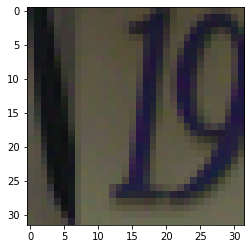

Digit Label:  9


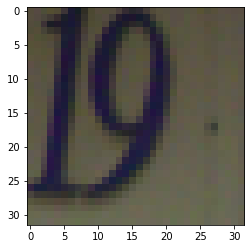

Digit Label:  2


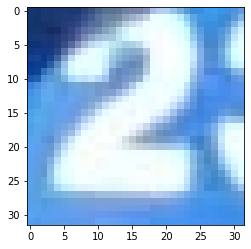

Digit Label:  3


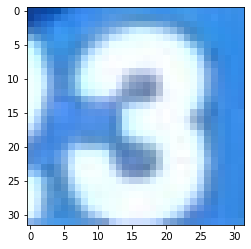

Digit Label:  2


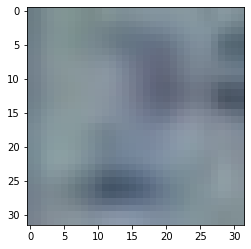

In [ ]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

train = loadmat('train_32x32.mat')

train_X = train['X']
train_y = train['y']

# Replacing all the labels “10“ with label “0”
for i in range(len(train_y)):
  digit = int(train_y[i])
  if(digit == 10):
    train_y[i] = 0

# displaying example images
for i in range(5):
  digit = int(train_y[i])
  print('Digit Label: ', digit)
  plt.imshow(train_X[:,:,:,i])
  plt.show()

In [1]:
!pip install boto3

     |████████████████████████████████| 133kB 14.4MB/s 
     |████████████████████████████████| 7.2MB 14.6MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 143kB 63.6MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Done transferring all datasets


loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


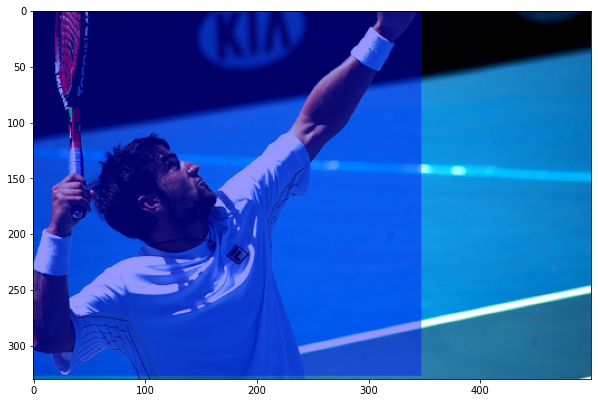

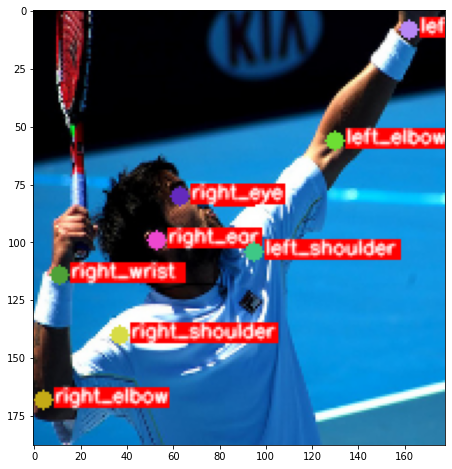

In [24]:
from pycocotools.coco import COCO
import json
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import cv2

# function to draw keypoints on image
def draw_keypoints(image):
  kp_img = image.copy()
  for idx, k in enumerate(range(len(keypoint_text))):
    x = 'x'+ str(idx)
    y = 'y'+ str(idx)
    v = 'v'+ str(idx)
    text = keypoint_text[idx]
    visible = int(keypoint_df[v])

    rect_width = len(text)*4.6
    rect_height = 5
    
    if(visible == 2):
      
      # adjusted keypoint location in resized image
      adjusted_pt = get_scaled_point(keypoint_df[x],keypoint_df[y])
      pt_x = adjusted_pt[0]
      pt_y = adjusted_pt[1]
      # draw circle at keypoint location
      clr = list(np.random.random(size=3) * 256)
      kp_img = cv2.circle(kp_img, center=(pt_x, pt_y), radius=4, color= clr, thickness= -1)
      # draw background rectangle for text
      pt1 = (pt_x+5, pt_y+3)
      pt2 = ((pt_x+4) + rect_width, pt_y - rect_height)      
      cv2.rectangle(kp_img, pt1, pt2, color_red, cv2.FILLED)
      # Putting text on keypoints
      pt = (pt_x+5,pt_y+1)
      cv2.putText(kp_img,text, pt, font, scale, color_white, thickness, cv2.LINE_AA)
  
  return kp_img

def get_scaled_point(x,y):
  return (round(x*scale_factor[0]), round(y*scale_factor[1])) 

# variable initialization
path = '/content/'
kp_json = path + 'annotations/person_keypoints_val2017.json'
bbox,keypoints,kp_cols,kp_list,pts_list,new_bbox_coord = [],[],[],[],[],[]
img_id = 521956
scale = 0.28
font = cv2.FONT_HERSHEY_SIMPLEX
thickness = 1
color_red = (255, 0, 0)
color_white = (255, 255, 255)
color_blue = (0, 0, 255)
alpha = 0.4
resize_h = 192
resize_w = 256

# load annotations using coco api
coco = COCO(kp_json)
img_descriptor = coco.loadImgs(img_id)
gt_ann_ids = coco.getAnnIds(imgIds=[img_id])
gt_anns = coco.loadAnns(gt_ann_ids)

# get image, bounding box, keypoints 
file_name = img_descriptor[0]['file_name']
img = io.imread(path + "val2017/" + file_name)
for gt in gt_anns:
  bbox = gt['bbox']
  keypoints = gt['keypoints'] 

# Read keypoints from json file into dataframe
with open(kp_json, "r") as f:
    data = json.load(f)
categories = data['categories']
for cat in categories:
  keypoint_text = cat['keypoints']

for idx, k in enumerate(range(len(keypoint_text))):
  kp_cols.append('x'+ str(idx))
  kp_cols.append('y'+ str(idx))
  kp_cols.append('v'+ str(idx))
keypoint_df = pd.DataFrame(data=[keypoints],columns=kp_cols,index=None)

# show bounding box on image
img_bbox = img.copy() 
img_bbox = cv2.rectangle(img_bbox,(int(bbox[0]),int(bbox[1])),(int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])),color_blue,-1)
img_bbox = cv2.addWeighted(img_bbox, alpha, img, 1 - alpha, 0)
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img_bbox)

# Resize image
scale_factor = np.flipud(np.divide((resize_h,resize_w), img.shape[:2]))
resized_img = img.copy()
resized_img = cv2.resize(resized_img, (0,0), fx=scale_factor[0], fy=scale_factor[1]) 

# draw keypoints
new_image = draw_keypoints(resized_img)

# get new bounding box points in resized image
bbox_coord = [(int(bbox[0]),int(bbox[1])),(int(bbox[0]+bbox[2]),int(bbox[1])),(int(bbox[0]),int(bbox[1])+int(bbox[3])),(int(bbox[0]+bbox[2]),int(bbox[1])+int(bbox[3]))]
for bb in bbox_coord:
  new_pt = get_scaled_point(bb[0],bb[1])
  new_bbox_coord.append(new_pt)

# crop image by bounding box
img_crop = new_image.copy()
img_crop = img_crop[new_bbox_coord[0][1]:new_bbox_coord[3][1], new_bbox_coord[0][0]:new_bbox_coord[3][0]]
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img_crop)
